## triplet

In [ ]:
import re
import bs4
import spacy
import pandas as pd
from spacy import displacy
nlp = spacy.load('zh_core_web_sm')

from spacy.matcher import Matcher
from spacy.tokens import Span

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.764 seconds.
Prefix dict has been built successfully.


In [16]:
read_num = 5
fraud_list = []
nonfraud_list = []
labels = []
filename = 'case.txt'

def read_some_doc(read_num):
    with open(filename,'r') as f:
        fraudNum = 0
        nonfraudNum = 0
        while True: 
            line = f.readline()
            line = line.strip('\n')
            label = int(line[-1])

            if fraudNum >= read_num and nonfraudNum >= read_num:
                break

            if label == 0:
                if nonfraudNum >= read_num:
                    continue
                else:
                    nonfraudNum += 1
                    nonfraud_list.append(re.sub("[（）？！]", '', line[:-2].strip('\t')) )
            else:
                if fraudNum >= read_num:
                    continue
                else:
                    fraudNum += 1
                    fraud_list.append(re.sub("[（）？！]", '', line[:-2].strip('\t')) )

    f.close()
    
def read_all_doc():
    with open(filename,'r') as f:
        for line in f.readlines():
            line = line.strip('\n')
            if line[-1] == '1':
                fraud_list.append(re.sub("[（）？！]", '', line[:-2].strip('\t')) )
            if line[-1] == '0':
                nonfraud_list.append(re.sub("[（）？！]", '', line[:-2].strip('\t')) )
    f.close()
    
read_all_doc()

In [18]:
len(fraud_list),len(nonfraud_list)

(2000, 300)

In [4]:
def get_triplet(sent):
    flag = 0
    subj = ""
    obj = ""
    verb = ""
    segments = nlp(sent)
    
    if segments[0].pos_ == 'VERB':
        verb = segments[0].text
        for tok in segments[1:]:
            if tok.pos_ == 'ADJ' or tok.dep_ == 'amod':
                obj = tok.text
            elif tok.dep_ == 'dobj':
                subj = tok.text
                
    elif segments[-1].pos_ == 'VERB':
        subj = segments[-1].text
        for tok in segments[0:-1]:
            if tok.pos_ == 'NOUN':
                verb = tok.text
            elif tok.pos_ == 'ADV':
                obj = tok.text
                
    else:
        for tok in nlp(sent):
            if tok.pos_ == 'VERB' and verb=='':
                flag = 1
                verb = tok.text
            elif flag == 0:
                if tok.pos_ != 'PROPN':
                    subj += tok.text
            else:
                if tok.pos_ != 'NUM' and tok.dep_ != 'compound:nn':
                    obj += tok.text
    return (subj,obj,verb)

In [19]:
keywords_list = ['疑点','支持','驳回','虚假','不予','予以',
                 '撤销','冒用','错误']

kwd_pattern_dic = {'疑点':[[{'POS':'NOUN'},
                          {'POS':'VERB'}, 
                          {'DEP':'dep','OP':'?'},
                          {'LOWER': '疑点'}]],
                   
                   '支持':[[{'POS':'NOUN'},
                          {'POS':'VERB'}, 
                          {'DEP':'dep','OP':'?'},
                          {'LOWER': '支持'}] ],
                  
                   '驳回':[[{'POS':'NOUN'},
                           {'LOWER': '驳回'},
                           {'DEP':'compound:nn','OP':'?'},
                           {'POS':'NOUN'}]],
                  
                  '虚假':[[{'POS':'VERB'}, 
                           {'LOWER': '虚假'},
                           {'POS':'VERB'}],
                        
                           [{'POS':'VERB'}, 
                           {'LOWER': '虚假'},
                           {'DEP':'compound:nn','OP':'?'},
                           {'DEP':'compound:nn','OP':'?'},
                           {'DEP':'compound:nn','OP':'?'},
                           {'DEP':'dobj'}],
                       
                           [{'POS':'NOUN'},
                           {'POS':'PUNCT','OP':'?'},
                           {'POS':'VERB'}, 
                           {'LOWER': '虚假'}]],
                  
                  '不予':[[{'POS':'NOUN'},
                           {'LOWER': '不予'},
                           {'POS':'NOUN'}]],
                  
                  '予以':[[{'POS':'NOUN'},
                           {'LOWER': '予以'},
                           {'DEP':'compound:nn','OP':'?'},
                           {'POS':'NOUN'}]],
                  
                  '撤销':[[{'POS':'ADV'},
                           {'LOWER': '撤销'},
                           {'DEP':'amod','OP':'?'},
                           {'DEP':'compound:nn','OP':'?'},
                           {'POS':'NOUN'}]],
                  
                  '冒用':[[{'POS':'NOUN'},
                           {'POS':'PROPN','OP':'?'},
                           {'LOWER': '冒用'},
                           {'POS':'PRON'},
                           {'POS':'PART','OP':'?'},
                           {'POS':'NOUN'}]],
                  
                  '错误':[[{'POS':'VERB'},
                           {'POS':'NOUN'},
                           {'POS':'NOUN','OP':'?'},
                           {'DEP':'cc','OP':'?'},
                           {'DEP':'compound:nn','OP':'?'},
                           {'LOWER': '错误'}]]}
            # Matcher class object
matcher = Matcher(nlp.vocab)
cnt = 1
for kwd in keywords_list:
    for pattern in kwd_pattern_dic[kwd]:
        name = "matcher_" + str(cnt)
        cnt += 1
        matcher.add(name,None,pattern)

In [20]:
fraud_sent_list = []
for i in range(len(fraud_list)):
    fraud_sent_list.append(re.sub("[：；]", '。', fraud_list[i]).split('。'))
    
nonfraud_sent_list = []
for i in range(len(nonfraud_list)):
    nonfraud_sent_list.append(re.sub("[：；]", '。', nonfraud_list[i]).split('。'))

In [21]:
def get_triplet_list(sent_list):
    triplet_list = []
    for i in range(len(sent_list)):
        tmp_triplet_container = []
        for j in range(len(sent_list[i])):
            for k in keywords_list:
                #print(k)
                if k in sent_list[i][j]:
                    #cnt += 1
                    doc = nlp(sent_list[i][j])          
                    matches = matcher(doc)
                    for match in matches:
                        triplet = get_triplet(doc[match[1]:match[2]].text)
                        if '' not in triplet and triplet not in tmp_triplet_container:
                            tmp_triplet_container.append(triplet)
        triplet_list.append(tmp_triplet_container)
    return triplet_list

In [33]:
fraud_triplet_list = get_triplet_list(fraud_sent_list)
fraud_triplet_list[0]

[('流水', '证明', '予以'),
 ('本院', '确认', '予以'),
 ('诉讼', '虚假', '属于'),
 ('法院', '准许', '不予'),
 ('判决', '请求', '驳回'),
 ('离婚', '虚假', '系')]

In [39]:
# 保存
filename = open('fraud.txt', 'w')  
for value in fraud_triplet_list:  
     filename.write(str(value)) 
filename.close()  
# 读取
#f= open("a.txt","r")   
#a = f.read()    
#f.close()

In [32]:
nonfraud_triplet_list = get_triplet_list(nonfraud_sent_list)
nonfraud_triplet_list[0]

[('补助费', '认可', '不予'),
 ('误工费', '认可', '不予'),
 ('部分', '采信', '不予'),
 ('部分', '采信', '予以'),
 ('证据', '采信', '不予'),
 ('意见', '采纳', '予以'),
 ('威信', '支持', '治疗')]

### visualization
#### fraud KG

In [10]:
import networkx as nx

import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth',200)

In [51]:
flatten_fraud_triplet_list = list()
for i in fraud_triplet_list:
    flatten_fraud_triplet_list.extend(i)
flatten_fraud_triplet_set = list(set(flatten_fraud_triplet_list))
flatten_fraud_triplet_set[:10]

[('人', '虚假', '提起'),
 ('房产', '解封', '予以'),
 ('问题', '虚假', '制造'),
 ('预案', '支持', '不予'),
 ('责任，', '虚假', '含有'),
 ('蒯金芳', '虚假', '实施'),
 ('情况', '参考', '予以'),
 ('本院', '原告', '驳回'),
 ('房屋', '查封', '予以'),
 ('本案', '虚假', '涉嫌')]

In [52]:
# extract subject
source = [i[0] for i in flatten_fraud_triplet_set]

# extract object
target = [i[1] for i in flatten_fraud_triplet_set]

# extract relations
relations = [i[2] for i in flatten_fraud_triplet_set]

kg_df = pd.DataFrame({'source':source, 'target':target,'edge':relations})

In [53]:
# create a directed-graph from a dataframe
G = nx.from_pandas_edgelist(kg_df,"source","target",
                  edge_attr=True, create_using=nx.MultiDiGraph())

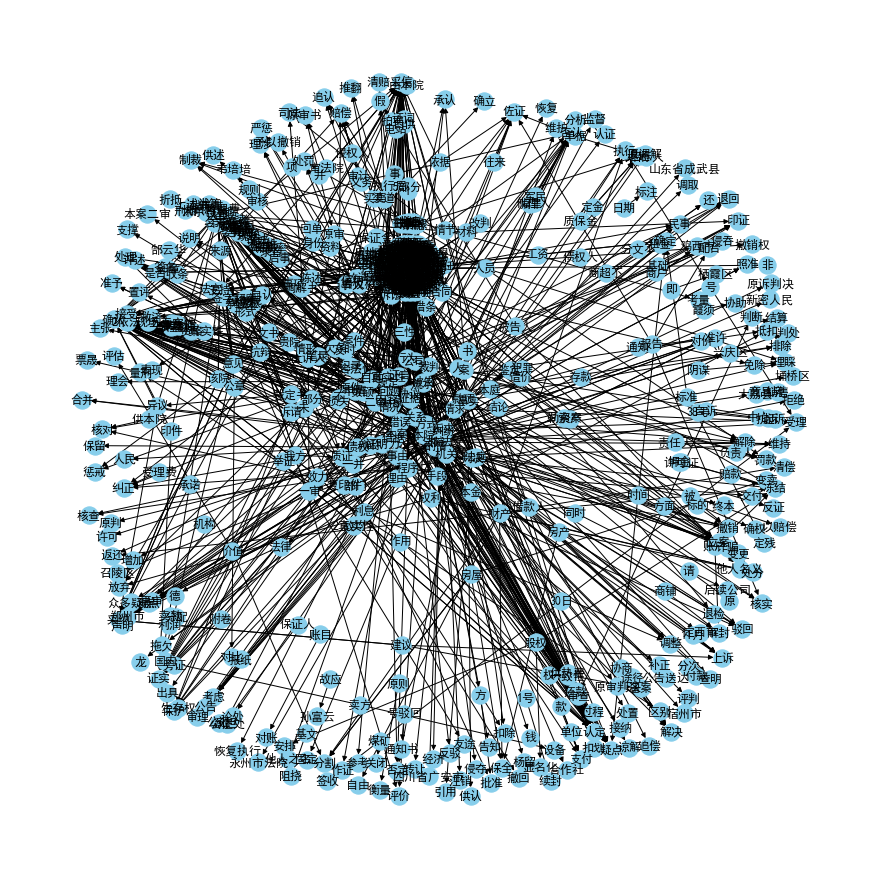

In [54]:
# plot the network
plt.figure(figsize=(12,12))
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['font.family']='sans-serif'

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True,node_color='skyblue',edge_cmap=plt.cm.Blues,pos=pos)
plt.savefig('fraud.png')
plt.show()

#### nonfraud KG

In [29]:
flatten_nonfraud_triplet_list = list()
for i in nonfraud_triplet_list:
    flatten_nonfraud_triplet_list.extend(i)
flatten_nonfraud_triplet_set = list(set(flatten_nonfraud_triplet_list))
flatten_nonfraud_triplet_set[:10]

[('公司', '承担', '不予'),
 ('比例', '分担', '予以'),
 ('公司', '认可', '不予'),
 ('审核', '确认', '予以'),
 ('本院', '尊重', '予以'),
 ('顺序', '抵充', '予以'),
 ('本院', '支持', '不予'),
 ('本院', '采信', '不予'),
 ('证据', '认定', '予以'),
 ('裁定书', '原告', '驳回')]

In [45]:
# extract subject
source = [i[0] for i in flatten_nonfraud_triplet_set]

# extract object
target = [i[1] for i in flatten_nonfraud_triplet_set]

# extract relations
relations = [i[2] for i in flatten_nonfraud_triplet_set]

kg_df = pd.DataFrame({'source':source, 'target':target,'edge':relations})

In [46]:
# create a directed-graph from a dataframe
G = nx.from_pandas_edgelist(kg_df,"source","target",
                  edge_attr=True, create_using=nx.MultiDiGraph())

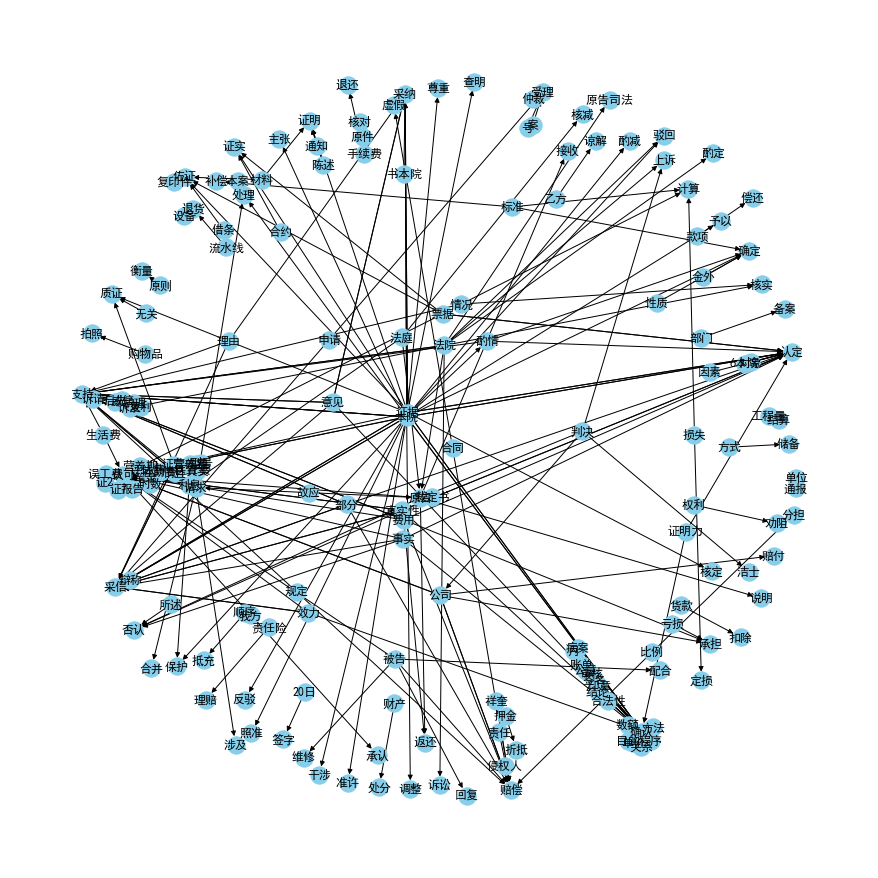

In [50]:
# plot the network
plt.figure(figsize=(12,12))
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['font.family']='sans-serif'

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True,node_color='skyblue',edge_cmap=plt.cm.Blues,pos=pos)
plt.savefig('nonfraud.png')
plt.show()